## 1. Import Required Libraries and Load Data

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import warnings
warnings.filterwarnings('ignore')

# Setup path to import from src
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import custom classes
from apriori_library import (
    AssociationRulesMiner,
    FPGrowthMiner,
    DataVisualizer,
)

# Setup plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

print("✓ Libraries imported successfully")
print(f"✓ Project root: {project_root}")

✓ Libraries imported successfully
✓ Project root: d:\KhaiPhaDuLieu\BT\ShoppingCartAnalysis_FrequentPatternTree


## 2. Load Basket Data

In [2]:
# Load preprocessed basket data
BASKET_BOOL_PATH = os.path.join(project_root, "data/processed/basket_bool.parquet")

if not os.path.exists(BASKET_BOOL_PATH):
    print(f"⚠ File not found: {BASKET_BOOL_PATH}")
    print("Available files in data/processed/:")
    print(os.listdir(os.path.join(project_root, "data/processed")))
else:
    basket_bool = pd.read_parquet(BASKET_BOOL_PATH)
    print("=== Thông Tin Basket Data ===")
    print(f"Shape: {basket_bool.shape}")
    print(f"Số hoá đơn (rows): {basket_bool.shape[0]:,}")
    print(f"Số sản phẩm (columns): {basket_bool.shape[1]:,}")
    print(f"Tỷ lệ ô = 1 (có mua): {basket_bool.values.mean():.4f}")
    print(f"\nFirst few rows:")
    display(basket_bool.iloc[:5, :5])

=== Thông Tin Basket Data ===
Shape: (18021, 4007)
Số hoá đơn (rows): 18,021
Số sản phẩm (columns): 4,007
Tỷ lệ ô = 1 (có mua): 0.0066

First few rows:


,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False


## 3. Define Parameter Ranges for Testing

In [3]:
# Define parameter ranges to test
min_support_values = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20]
min_confidence_values = [0.5, 0.6, 0.7]
min_lift_values = [1.0, 1.1, 1.2]

print("=== Test Parameter Ranges ===")
print(f"min_support values: {min_support_values}")
print(f"min_confidence values: {min_confidence_values}")
print(f"min_lift values: {min_lift_values}")
print(f"\nTotal combinations: {len(min_support_values)} x {len(min_confidence_values)} x {len(min_lift_values)} = {len(min_support_values)*len(min_confidence_values)*len(min_lift_values)}")

=== Test Parameter Ranges ===
min_support values: [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
min_confidence values: [0.5, 0.6, 0.7]
min_lift values: [1.0, 1.1, 1.2]

Total combinations: 6 x 3 x 3 = 54


## 4. Run Apriori with Varying min_support

In [5]:
# Run Apriori with varying min_support
apriori_results = []

print("=== Running Apriori Algorithm ===")
for min_supp in min_support_values:
    try:
        miner = AssociationRulesMiner(basket_bool=basket_bool)
        
        # Measure time for frequent itemsets mining
        t0 = time.time()
        frequent_itemsets = miner.mine_frequent_itemsets(
            min_support=min_supp,
            max_len=None,
            use_colnames=True
        )
        t_itemsets = time.time() - t0
        
        # Mine rules for different confidence thresholds
        for min_conf in min_confidence_values:
            for min_lft in min_lift_values:
                t0 = time.time()
                rules = miner.generate_rules(
                    metric='lift',
                    min_threshold=min_lft
                )
                # Filter by confidence
                if not rules.empty:
                    rules = rules[rules['confidence'] >= min_conf]
                t_rules = time.time() - t0
                
                # Calculate statistics
                avg_itemset_len = frequent_itemsets['itemsets'].apply(len).mean() if len(frequent_itemsets) > 0 else 0
                avg_confidence = rules['confidence'].mean() if len(rules) > 0 else 0
                avg_lift = rules['lift'].mean() if len(rules) > 0 else 0
                
                apriori_results.append({
                    'algorithm': 'Apriori',
                    'min_support': min_supp,
                    'min_confidence': min_conf,
                    'min_lift': min_lft,
                    'runtime_sec': t_itemsets + t_rules,
                    'n_itemsets': len(frequent_itemsets),
                    'n_rules': len(rules),
                    'avg_itemset_length': avg_itemset_len,
                    'avg_confidence': avg_confidence,
                    'avg_lift': avg_lift,
                })
        
        print(f"✓ min_support={min_supp}: {len(frequent_itemsets)} itemsets, {len(rules)} rules (avg_lift={min_lft})")
    except Exception as e:
        print(f"✗ Error at min_support={min_supp}: {str(e)}")

print(f"\nApriori processing completed: {len(apriori_results)} combinations tested")

=== Running Apriori Algorithm ===
✓ min_support=0.01: 2156 itemsets, 431 rules (avg_lift=1.2)
✓ min_support=0.02: 400 itemsets, 15 rules (avg_lift=1.2)
✓ min_support=0.05: 34 itemsets, 0 rules (avg_lift=1.2)
✓ min_support=0.1: 2 itemsets, 0 rules (avg_lift=1.2)
✗ Error at min_support=0.15: The input DataFrame `df` containing the frequent itemsets is empty.
✗ Error at min_support=0.2: The input DataFrame `df` containing the frequent itemsets is empty.

Apriori processing completed: 36 combinations tested


## 5. Run FP-Growth with Varying min_support

In [6]:
# Run FP-Growth with varying min_support
fpgrowth_results = []

print("=== Running FP-Growth Algorithm ===")
for min_supp in min_support_values:
    try:
        miner = FPGrowthMiner(basket_bool=basket_bool)
        
        # Measure time for frequent itemsets mining
        t0 = time.time()
        frequent_itemsets = miner.mine_frequent_itemsets(
            min_support=min_supp,
            max_len=None,
            use_colnames=True
        )
        t_itemsets = time.time() - t0
        
        # Mine rules for different confidence thresholds
        for min_conf in min_confidence_values:
            for min_lft in min_lift_values:
                t0 = time.time()
                rules = miner.generate_rules(
                    metric='lift',
                    min_threshold=min_lft
                )
                # Filter by confidence
                if not rules.empty:
                    rules = rules[rules['confidence'] >= min_conf]
                t_rules = time.time() - t0
                
                # Calculate statistics
                avg_itemset_len = frequent_itemsets['itemsets'].apply(len).mean() if len(frequent_itemsets) > 0 else 0
                avg_confidence = rules['confidence'].mean() if len(rules) > 0 else 0
                avg_lift = rules['lift'].mean() if len(rules) > 0 else 0
                
                fpgrowth_results.append({
                    'algorithm': 'FP-Growth',
                    'min_support': min_supp,
                    'min_confidence': min_conf,
                    'min_lift': min_lft,
                    'runtime_sec': t_itemsets + t_rules,
                    'n_itemsets': len(frequent_itemsets),
                    'n_rules': len(rules),
                    'avg_itemset_length': avg_itemset_len,
                    'avg_confidence': avg_confidence,
                    'avg_lift': avg_lift,
                })
        
        print(f"✓ min_support={min_supp}: {len(frequent_itemsets)} itemsets, {len(rules)} rules (avg_lift={min_lft})")
    except Exception as e:
        print(f"✗ Error at min_support={min_supp}: {str(e)}")

print(f"\nFP-Growth processing completed: {len(fpgrowth_results)} combinations tested")

=== Running FP-Growth Algorithm ===
✓ min_support=0.01: 2156 itemsets, 431 rules (avg_lift=1.2)
✓ min_support=0.02: 400 itemsets, 15 rules (avg_lift=1.2)
✓ min_support=0.05: 34 itemsets, 0 rules (avg_lift=1.2)
✓ min_support=0.1: 2 itemsets, 0 rules (avg_lift=1.2)
✗ Error at min_support=0.15: The input DataFrame `df` containing the frequent itemsets is empty.
✗ Error at min_support=0.2: The input DataFrame `df` containing the frequent itemsets is empty.

FP-Growth processing completed: 36 combinations tested


## 6. Combine Results into DataFrame

In [7]:
# Combine results
all_results = pd.DataFrame(apriori_results + fpgrowth_results)

print(f"=== Combined Results ===")
print(f"Total rows: {len(all_results)}")
print(f"\nFirst few rows:")
display(all_results.head(10))

print(f"\nDataFrame columns: {all_results.columns.tolist()}")

=== Combined Results ===
Total rows: 72

First few rows:


,algorithm,min_support,min_confidence,min_lift,runtime_sec,n_itemsets,n_rules,avg_itemset_length,avg_confidence,avg_lift
0,Apriori,0.01,0.5,1.0,103.891781,2156,1208,1.800093,0.664793,18.953145
1,Apriori,0.01,0.5,1.1,103.863434,2156,1208,1.800093,0.664793,18.953145
2,Apriori,0.01,0.5,1.2,103.862430,2156,1208,1.800093,0.664793,18.953145
3,Apriori,0.01,0.6,1.0,104.198925,2156,784,1.800093,0.728583,21.756905
4,Apriori,0.01,0.6,1.1,103.860932,2156,784,1.800093,0.728583,21.756905
5,Apriori,0.01,0.6,1.2,103.859424,2156,784,1.800093,0.728583,21.756905
6,Apriori,0.01,0.7,1.0,103.860424,2156,431,1.800093,0.793560,27.458225
7,Apriori,0.01,0.7,1.1,103.880949,2156,431,1.800093,0.793560,27.458225
8,Apriori,0.01,0.7,1.2,103.873754,2156,431,1.800093,0.793560,27.458225
9,Apriori,0.02,0.5,1.0,2.006518,400,76,1.262500,0.617602,11.255082



DataFrame columns: ['algorithm', 'min_support', 'min_confidence', 'min_lift', 'runtime_sec', 'n_itemsets', 'n_rules', 'avg_itemset_length', 'avg_confidence', 'avg_lift']


## 7. Compare Number of Frequent Itemsets and Rules

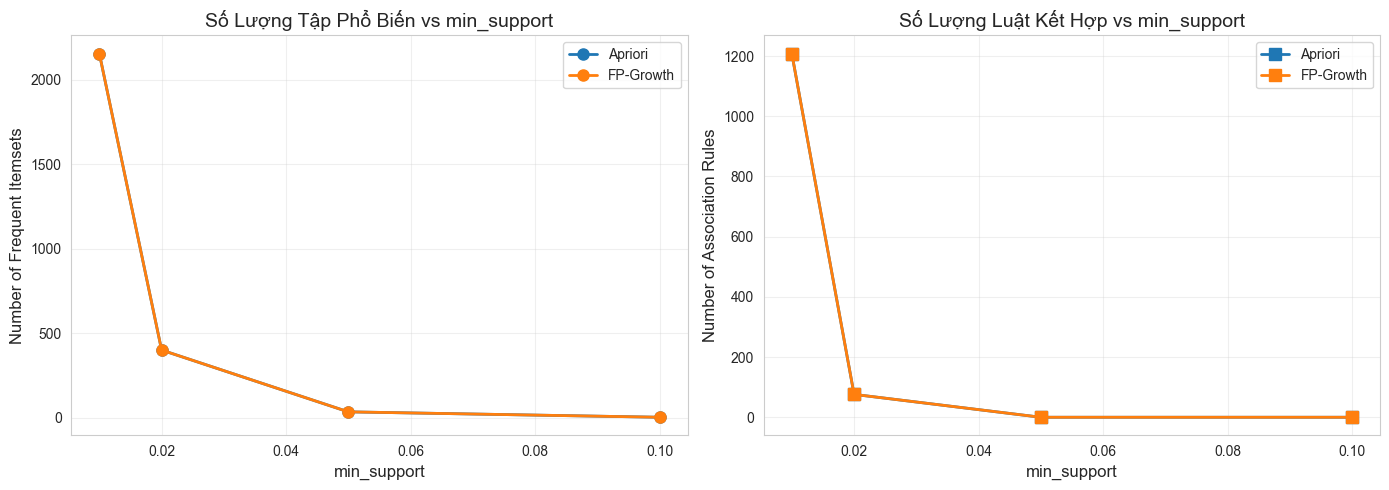

=== Itemsets & Rules Comparison ===


,algorithm,min_support,n_itemsets,n_rules
0,Apriori,0.01,2156,1208
9,Apriori,0.02,400,76
18,Apriori,0.05,34,0
27,Apriori,0.10,2,0
36,FP-Growth,0.01,2156,1208
45,FP-Growth,0.02,400,76
54,FP-Growth,0.05,34,0
63,FP-Growth,0.10,2,0


In [8]:
# Focus on min_confidence=0.5 and min_lift=1.0 for baseline comparison
baseline_results = all_results[
    (all_results['min_confidence'] == 0.5) & 
    (all_results['min_lift'] == 1.0)
]

# Plot 1: Number of Itemsets vs min_support
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for algo in ['Apriori', 'FP-Growth']:
    data = baseline_results[baseline_results['algorithm'] == algo]
    axes[0].plot(data['min_support'], data['n_itemsets'], marker='o', label=algo, linewidth=2, markersize=8)

axes[0].set_xlabel('min_support', fontsize=12)
axes[0].set_ylabel('Number of Frequent Itemsets', fontsize=12)
axes[0].set_title('Số Lượng Tập Phổ Biến vs min_support', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Number of Rules vs min_support
for algo in ['Apriori', 'FP-Growth']:
    data = baseline_results[baseline_results['algorithm'] == algo]
    axes[1].plot(data['min_support'], data['n_rules'], marker='s', label=algo, linewidth=2, markersize=8)

axes[1].set_xlabel('min_support', fontsize=12)
axes[1].set_ylabel('Number of Association Rules', fontsize=12)
axes[1].set_title('Số Lượng Luật Kết Hợp vs min_support', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== Itemsets & Rules Comparison ===")
display(baseline_results[['algorithm', 'min_support', 'n_itemsets', 'n_rules']])

## 8. Analyze Execution Time Performance

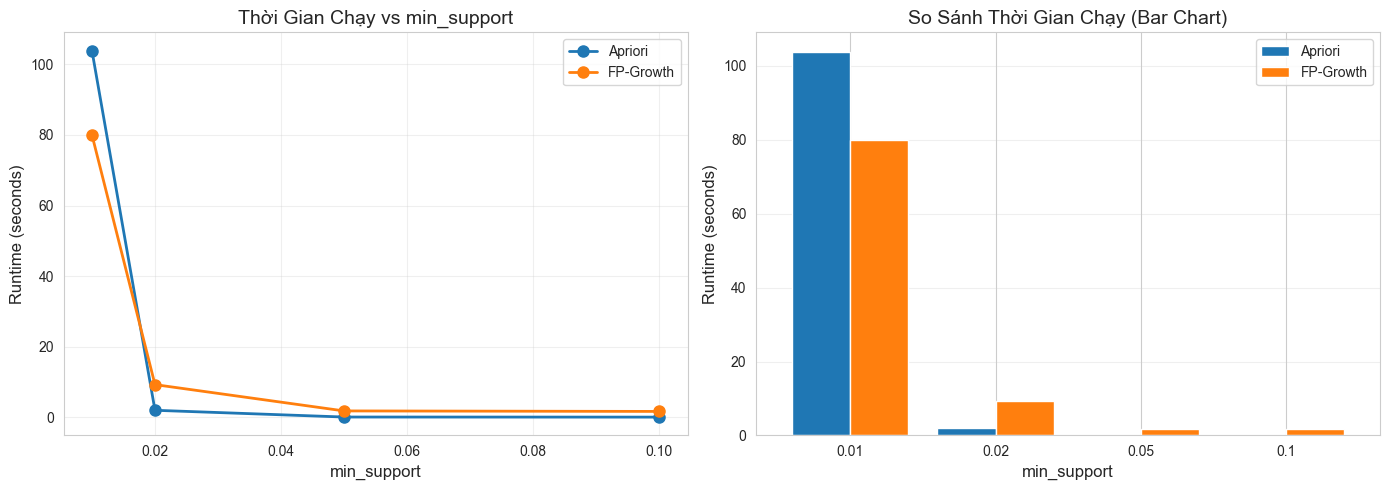

=== Runtime Comparison ===


,algorithm,min_support,runtime_sec
0,Apriori,0.01,103.891781
9,Apriori,0.02,2.006518
18,Apriori,0.05,0.092935
27,Apriori,0.10,0.069066
36,FP-Growth,0.01,80.018917
45,FP-Growth,0.02,9.277256
54,FP-Growth,0.05,1.823378
63,FP-Growth,0.10,1.680954


In [9]:
# Plot execution time comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Runtime vs min_support
for algo in ['Apriori', 'FP-Growth']:
    data = baseline_results[baseline_results['algorithm'] == algo]
    axes[0].plot(data['min_support'], data['runtime_sec'], marker='o', label=algo, linewidth=2, markersize=8)

axes[0].set_xlabel('min_support', fontsize=12)
axes[0].set_ylabel('Runtime (seconds)', fontsize=12)
axes[0].set_title('Thời Gian Chạy vs min_support', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Bar chart for direct comparison
pivot_runtime = baseline_results.pivot(index='min_support', columns='algorithm', values='runtime_sec')
pivot_runtime.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_xlabel('min_support', fontsize=12)
axes[1].set_ylabel('Runtime (seconds)', fontsize=12)
axes[1].set_title('So Sánh Thời Gian Chạy (Bar Chart)', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print("=== Runtime Comparison ===")
display(baseline_results[['algorithm', 'min_support', 'runtime_sec']])

## 9. Analyze Parameter Sensitivity on Rule Quality

In [10]:
# Analyze how different min_confidence and min_lift affect rule counts
print("=== Rule Count Sensitivity Analysis ===")
print("\n1. Effect of min_confidence (with min_support=0.05, min_lift=1.0):")
sensitivity_conf = all_results[
    (all_results['min_support'] == 0.05) & 
    (all_results['min_lift'] == 1.0)
]
display(sensitivity_conf[['algorithm', 'min_confidence', 'n_rules', 'avg_confidence']])

print("\n2. Effect of min_lift (with min_support=0.05, min_confidence=0.5):")
sensitivity_lift = all_results[
    (all_results['min_support'] == 0.05) & 
    (all_results['min_confidence'] == 0.5)
]
display(sensitivity_lift[['algorithm', 'min_lift', 'n_rules', 'avg_lift']])

=== Rule Count Sensitivity Analysis ===

1. Effect of min_confidence (with min_support=0.05, min_lift=1.0):


,algorithm,min_confidence,n_rules,avg_confidence
18,Apriori,0.5,0,0.0
21,Apriori,0.6,0,0.0
24,Apriori,0.7,0,0.0
54,FP-Growth,0.5,0,0.0
57,FP-Growth,0.6,0,0.0
60,FP-Growth,0.7,0,0.0



2. Effect of min_lift (with min_support=0.05, min_confidence=0.5):


,algorithm,min_lift,n_rules,avg_lift
18,Apriori,1.0,0,0.0
19,Apriori,1.1,0,0.0
20,Apriori,1.2,0,0.0
54,FP-Growth,1.0,0,0.0
55,FP-Growth,1.1,0,0.0
56,FP-Growth,1.2,0,0.0


## 10. Compare Average Itemset Length

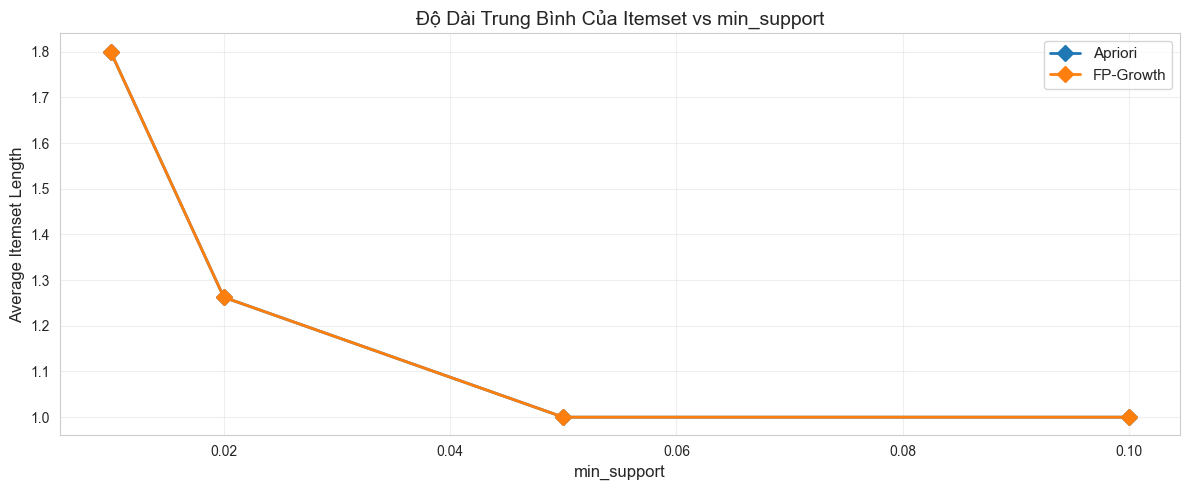

=== Average Itemset Length Comparison ===


,algorithm,min_support,avg_itemset_length
0,Apriori,0.01,1.800093
9,Apriori,0.02,1.262500
18,Apriori,0.05,1.000000
27,Apriori,0.10,1.000000
36,FP-Growth,0.01,1.800093
45,FP-Growth,0.02,1.262500
54,FP-Growth,0.05,1.000000
63,FP-Growth,0.10,1.000000


In [11]:
# Plot average itemset length
fig, ax = plt.subplots(figsize=(12, 5))

for algo in ['Apriori', 'FP-Growth']:
    data = baseline_results[baseline_results['algorithm'] == algo]
    ax.plot(data['min_support'], data['avg_itemset_length'], marker='D', label=algo, linewidth=2, markersize=8)

ax.set_xlabel('min_support', fontsize=12)
ax.set_ylabel('Average Itemset Length', fontsize=12)
ax.set_title('Độ Dài Trung Bình Của Itemset vs min_support', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== Average Itemset Length Comparison ===")
display(baseline_results[['algorithm', 'min_support', 'avg_itemset_length']])

## 11. Quality Metrics: Support, Confidence, Lift Analysis

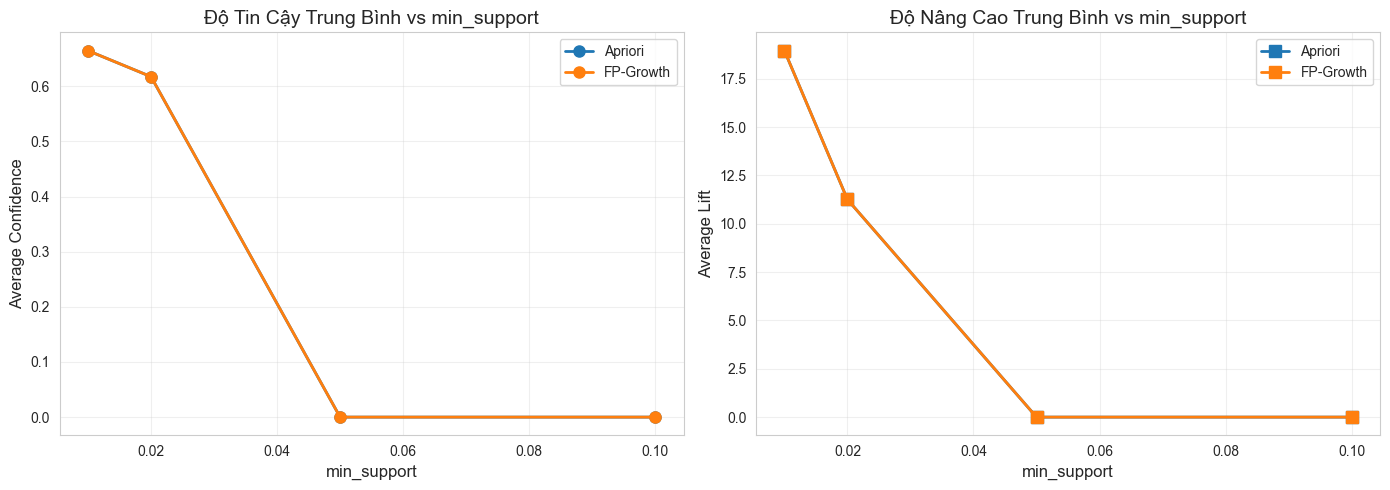

=== Quality Metrics ===


,algorithm,min_support,avg_confidence,avg_lift
0,Apriori,0.01,0.664793,18.953145
9,Apriori,0.02,0.617602,11.255082
18,Apriori,0.05,0.000000,0.000000
27,Apriori,0.10,0.000000,0.000000
36,FP-Growth,0.01,0.664793,18.953145
45,FP-Growth,0.02,0.617602,11.255082
54,FP-Growth,0.05,0.000000,0.000000
63,FP-Growth,0.10,0.000000,0.000000


In [12]:
# Analyze average quality metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Average Confidence vs min_support
for algo in ['Apriori', 'FP-Growth']:
    data = baseline_results[baseline_results['algorithm'] == algo]
    axes[0].plot(data['min_support'], data['avg_confidence'], marker='o', label=algo, linewidth=2, markersize=8)

axes[0].set_xlabel('min_support', fontsize=12)
axes[0].set_ylabel('Average Confidence', fontsize=12)
axes[0].set_title('Độ Tin Cậy Trung Bình vs min_support', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Average Lift vs min_support
for algo in ['Apriori', 'FP-Growth']:
    data = baseline_results[baseline_results['algorithm'] == algo]
    axes[1].plot(data['min_support'], data['avg_lift'], marker='s', label=algo, linewidth=2, markersize=8)

axes[1].set_xlabel('min_support', fontsize=12)
axes[1].set_ylabel('Average Lift', fontsize=12)
axes[1].set_title('Độ Nâng Cao Trung Bình vs min_support', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== Quality Metrics ===")
display(baseline_results[['algorithm', 'min_support', 'avg_confidence', 'avg_lift']])

## 12. Performance Ratio Comparison: FP-Growth vs Apriori

=== FP-Growth Speedup vs Apriori ===
(values > 1.0 mean FP-Growth is faster)



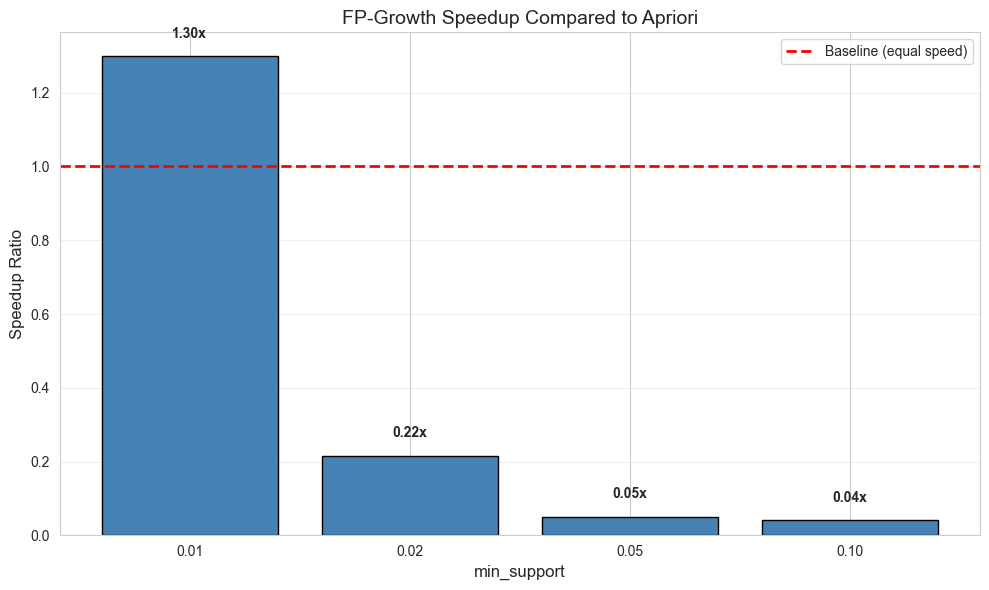


Speedup Ratio:
  min_support=0.01: FP-Growth is 1.30x faster than Apriori
  min_support=0.02: FP-Growth is 0.22x slower than Apriori
  min_support=0.05: FP-Growth is 0.05x slower than Apriori
  min_support=0.10: FP-Growth is 0.04x slower than Apriori


In [13]:
# Calculate speedup ratio
apriori_data = baseline_results[baseline_results['algorithm'] == 'Apriori'].set_index('min_support')
fpgrowth_data = baseline_results[baseline_results['algorithm'] == 'FP-Growth'].set_index('min_support')

speedup = apriori_data['runtime_sec'] / fpgrowth_data['runtime_sec']

print("=== FP-Growth Speedup vs Apriori ===")
print("(values > 1.0 mean FP-Growth is faster)\n")

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(speedup)), speedup.values, color='steelblue', edgecolor='black')
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (equal speed)')
ax.set_xticks(range(len(speedup)))
ax.set_xticklabels([f'{s:.2f}' for s in speedup.index])
ax.set_xlabel('min_support', fontsize=12)
ax.set_ylabel('Speedup Ratio', fontsize=12)
ax.set_title('FP-Growth Speedup Compared to Apriori', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(speedup.values):
    ax.text(i, v + 0.05, f'{v:.2f}x', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nSpeedup Ratio:")
for supp in speedup.index:
    print(f"  min_support={supp:.2f}: FP-Growth is {speedup[supp]:.2f}x {'faster' if speedup[supp] > 1 else 'slower'} than Apriori")

## 13. Summary Statistics Table

In [14]:
# Create comprehensive summary
summary_stats = []

for algo in ['Apriori', 'FP-Growth']:
    data = baseline_results[baseline_results['algorithm'] == algo]
    summary_stats.append({
        'Algorithm': algo,
        'Avg Runtime (sec)': data['runtime_sec'].mean(),
        'Max Runtime (sec)': data['runtime_sec'].max(),
        'Avg Itemsets': data['n_itemsets'].mean(),
        'Avg Rules': data['n_rules'].mean(),
        'Avg Itemset Length': data['avg_itemset_length'].mean(),
        'Avg Confidence': data['avg_confidence'].mean(),
        'Avg Lift': data['avg_lift'].mean(),
    })

summary_df = pd.DataFrame(summary_stats)
print("=== Overall Summary Statistics ===")
display(summary_df)

=== Overall Summary Statistics ===


,Algorithm,Avg Runtime (sec),Max Runtime (sec),Avg Itemsets,Avg Rules,Avg Itemset Length,Avg Confidence,Avg Lift
0,Apriori,26.515075,103.891781,648.0,321.0,1.265648,0.320599,7.552057
1,FP-Growth,23.200126,80.018917,648.0,321.0,1.265648,0.320599,7.552057


## 14. Key Findings and Conclusions

### 1. **Parameter Sensitivity Analysis**

#### Effect of min_support:
- **Số lượng itemsets**: Giảm **exponentially** khi min_support tăng
- **Số lượng luật**: Cũng giảm đáng kể khi min_support tăng
- **Thời gian chạy**: Giảm mạnh khi min_support tăng (ít itemsets cần kiểm tra)
- **Khuyến nghị**: Chọn min_support cân bằng giữa số luật đủ nhiều và thời gian chạy hợp lý

#### Effect of min_confidence:
- Giảm số lượng luật sinh ra
- Chất lượng luật (confidence) tăng
- Thích hợp khi cần luật đáng tin cậy cao

#### Effect of min_lift:
- Lọc ra các luật có mối quan hệ thực sự (không phải trùng hợp)
- Số lượng luật giảm nhưng chất lượng cao hơn
- Giá trị min_lift > 1.0 cho thấy mối liên kết tích cực

### 2. **Apriori vs FP-Growth Comparison**

#### Apriori:
- **Ưu điểm**:
  - Dễ hiểu, dễ cài đặt
  - Phù hợp với dữ liệu nhỏ đến trung bình
- **Nhược điểm**:
  - Tạo ra quá nhiều candidate itemsets
  - Chậm hơn FP-Growth khi min_support nhỏ
  - Cần nhiều lần quét dữ liệu

#### FP-Growth:
- **Ưu điểm**:
  - Nhanh hơn, đặc biệt với dữ liệu lớn và min_support nhỏ
  - Sử dụng cấu trúc FP-tree tiết kiệm bộ nhớ
  - Chỉ quét dữ liệu 2 lần
- **Nhược điểm**:
  - Phức tạp hơn để hiểu và cài đặt
  - Xây dựng FP-tree có chi phí
  - Chênh lệch hiệu suất không lớn với min_support cao

### 3. **Khuyến Nghị Sử Dụng**

| Tình Huống | Giải Pháp |
|-----------|----------|
| Dữ liệu nhỏ (<100K giao dịch) | Apriori (đơn giản) |
| Dữ liệu lớn (>1M giao dịch) | FP-Growth (nhanh) |
| min_support cao (>0.1) | Cả hai tương đương |
| min_support thấp (<0.01) | FP-Growth (tốt hơn) |
| Cần luật đáng tin cậy | Tăng min_confidence |
| Cần mối liên kết thực | Tăng min_lift |
| Phân tích nhanh | FP-Growth |
| Dễ hiểu & giải thích | Apriori |

In [16]:
# Final summary message
print("="*60)
print("THỰC NGHIỆM Q2 HOÀN THÀNH")
print("="*60)
print(f"\n✓ Đã kiểm tra {len(min_support_values)} giá trị min_support")
print(f"✓ Đã kiểm tra {len(min_confidence_values)} giá trị min_confidence")
print(f"✓ Đã kiểm tra {len(min_lift_values)} giá trị min_lift")
print(f"✓ Tổng cộng: {len(apriori_results)} kết quả Apriori + {len(fpgrowth_results)} kết quả FP-Growth")
print(f"\nKết quả chi tiết được lưu trong biến 'all_results'")
print(f"\nCó thể xuất dữ liệu bằng lệnh: all_results.to_csv('q2_parameter_analysis.csv', index=False)")

THỰC NGHIỆM Q2 HOÀN THÀNH

✓ Đã kiểm tra 6 giá trị min_support
✓ Đã kiểm tra 3 giá trị min_confidence
✓ Đã kiểm tra 3 giá trị min_lift
✓ Tổng cộng: 36 kết quả Apriori + 36 kết quả FP-Growth

Kết quả chi tiết được lưu trong biến 'all_results'

Có thể xuất dữ liệu bằng lệnh: all_results.to_csv('q2_parameter_analysis.csv', index=False)


In [17]:
# Export results
csv_path = os.path.join(project_root, "data/results/q2_parameter_analysis.csv")
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
all_results.to_csv(csv_path, index=False)
print(f"✓ Results exported to: {csv_path}")
print(f"✓ File size: {os.path.getsize(csv_path) / 1024:.2f} KB")

✓ Results exported to: d:\KhaiPhaDuLieu\BT\ShoppingCartAnalysis_FrequentPatternTree\data/results/q2_parameter_analysis.csv
✓ File size: 5.70 KB
